# Optimal Gasoline Price Predictions Using ANFIS Regression

## 📄 Introduction

In the context of global economic development, forecasting gasoline prices has become a critical task due to their direct impact on various sectors, including transportation, logistics, and energy. A multitude of dynamic factors, such as crude oil prices, exchange rates, supply-demand changes, geopolitical tensions, and economic policies, influence the fluctuating nature of gasoline prices. As such, accurate prediction models are essential for decision-makers to stabilise operations, reduce uncertainty, and support strategic planning.

This notebook presents an implementation of the methodology proposed in the research article:

> **"Optimal Gasoline Price Predictions: Leveraging the ANFIS Regression Model"**  
> *Entesar Hamed I. Eliwa, Amr Mohamed El Koshiry, Tarek Abd El-Hafeez, and Ahmed Omar*

The study utilises the Adaptive Neuro-Fuzzy Inference System (ANFIS), a hybrid intelligent system that combines the learning capabilities of neural networks with the fuzzy logic qualitative approach. ANFIS is particularly effective in capturing nonlinear patterns within datasets, making it well-suited for time series forecasting and regression tasks such as gasoline price prediction.

This notebook will cover the following:

- An overview of the ANFIS model
- Preprocessing of gasoline price data
- Implementation of the ANFIS model using Python
- Training and evaluation of the model
- Visualisation and interpretation of results

By the end of this notebook, we aim to replicate and understand the performance of the ANFIS regression model as applied to predicting gasoline prices, in accordance with the methodology presented in the original research.

---

*Note: This notebook is intended for educational and research purposes, and reproduces key elements of the original paper's methodology using open-source tools.*


## 📊 Dataset Description

The dataset used in this study is sourced from the **U.S. Energy Information Administration (EIA)** and contains **weekly U.S. retail gasoline prices** (in dollars per gallon) across **all grades and formulations**.

### 🗓️ Time Span
- **Start Date:** April 5, 1993  
- **End Date:** July 31, 2023  
- **Total Samples:** 1,583 weekly observations

### 📈 Data Characteristics
- **Frequency:** Weekly (one sample per week)
- **Unit:** U.S. Dollars per Gallon
- **Type:** Univariate time series (only price is considered in this analysis)
- **Coverage:** Nationwide U.S. average prices for all gasoline grades and formulations

This dataset captures long-term historical trends and short-term fluctuations in gasoline prices, making it suitable for time series modeling and predictive analytics.

> 📎 *Note: The dataset is publicly available from the U.S. EIA website and can be accessed at:*  
> [https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=EMM_EPM0_PTE_NUS_DPG&f=W](https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=EMM_EPM0_PTE_NUS_DPG&f=W)

We will use this dataset to build and evaluate an ANFIS-based regression model to forecast future gasoline prices.


# 📦 Library Imports


This section includes all the essential libraries used throughout the notebook for data processing, modeling, visualization, and evaluation.


In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import os
import math
import warnings
import json
import pickle

# Suppress warnings and TensorFlow logs
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
logging.getLogger('tensorflow').disabled = True

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Stats & Preprocessing
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow import keras


E0000 00:00:1753730534.184677      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753730534.234394      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 📥 Loading the Dataset

We begin by loading the Excel file provided by the U.S. Energy Information Administration (EIA). The file contains multiple sheets; the relevant data for this project is located in the **'Data 1'** sheet.


In [2]:
# Read the Excel file and load specified sheets
sheets = pd.read_excel('/kaggle/input/u-s-energy-information-administration/EMM_EPM0_PTE_NUS_DPGw.xls',
                       sheet_name=['Contents', 'Data 1'])

# Extract the relevant sheets
df1 = sheets['Contents']
df2 = sheets['Data 1']

# Skip the first two rows which contain header info or notes
df = df2[2:]

# Reset the DataFrame index
df = df.reset_index(drop=True)

# Rename the columns for clarity
df.columns = ['Date', 'Price']

In [3]:

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Define start and end dates
start_date = pd.to_datetime('1993-04-05')
end_date = pd.to_datetime('2023-07-31')

# Filter rows between the start and end dates
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Reset index after filtering
df = df.reset_index(drop=True)

# Display first few rows to confirm
df.head()

,Date,Price
0,1993-04-05,1.068
1,1993-04-12,1.079
2,1993-04-19,1.079
3,1993-04-26,1.086
4,1993-05-03,1.086


In [4]:
df.shape

(1583, 2)

# 🧹 Data Preparation and Splitting

To train an accurate and generalizable model, the raw data needs to be cleaned, transformed, and scaled. We use a custom function `prepare_data()` to handle this.

### 🛠️ `prepare_data()` Function Overview

This function performs the following steps:

1. **Date Parsing**: Converts the `Date` column to `datetime` format.
2. **Feature Extraction**: Extracts `day`, `month`, and `year` from the `Date` column.
3. **Target Conversion**: Ensures the `Price` column is numeric.
4. **Missing Value Handling**: Drops rows where `Price` is missing.
5. **Outlier Removal**: Uses Z-score filtering to remove extreme outliers.
6. **Feature Selection**: Keeps only `day`, `month`, and `year` as input features.
7. **Standard Scaling**: Normalizes both input features (`X`) and target (`y`) using `StandardScaler`.


In [5]:
def prepare_data(df, target_col='Price'):
    """
    Prepares the data for modeling.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_col (str): The name of the target column.

    Returns:
        tuple: X_scaled, y_scaled, scaler_X, scaler_y, feature_cols
    """
    # Feature extraction
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['day'] = df['Date'].dt.day
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year

    # Convert target to numeric
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce')

    # Drop rows where target is NaN (from conversion)
    df = df.dropna(subset=[target_col])

    # Remove outliers
    z_scores = stats.zscore(df[target_col])
    df = df[abs(z_scores) < 3]

    # Feature selection
    feature_cols = ['day', 'month', 'year']
    X = df[feature_cols].copy()
    y = df[target_col].values.reshape(-1, 1)

    # Standard scaling
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    return X_scaled, y_scaled, scaler_X, scaler_y, feature_cols

# ✂️ Train-Test Split

After preprocessing, we split the dataset into `training` and `testing` sets using `train_test_split`. We use stratified sampling with pd.qcut() to maintain a balanced distribution of the target variable.

In [6]:
X_scaled, y_scaled, scaler_X, scaler_y, features = prepare_data(df)

# Train-test split with stratified sampling on target quantiles
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=pd.qcut(y_scaled.flatten(), q=5, labels=False)
)


# Adaptive Network-Based Fuzzy Inference System (ANFIS) Model Implementation

### 🔧 ANFIS Architecture

The **Adaptive Neuro-Fuzzy Inference System (ANFIS)** is a hybrid intelligent system that combines the benefits of neural networks and fuzzy logic. It is composed of **five distinct layers**, each with a specific role in processing the input data and generating an output.

---

1. **Fuzzification Layer**
This layer converts **crisp input values** into **fuzzy values** by applying predefined **membership functions (MFs)** to each input variable. These fuzzy values represent degrees of belonging to fuzzy sets.

2. **Rule Layer**
In this layer, fuzzy **IF–THEN rules** are generated by combining the membership functions. Each rule represents a relationship between input fuzzy sets and an output.

3. **Normalization Layer**
The **firing strengths** (weights) of the fuzzy rules are computed and **normalized** so that their sum equals 1. This ensures that the rule contributions are proportionally balanced.

4. **Defuzzification Layer**
This layer calculates the **output of each fuzzy rule**, typically using a linear function of the input variables. Each output is weighted by its corresponding normalized firing strength.

 5. **Summation Layer**
The final output of the ANFIS model is obtained by **aggregating the outputs** of all the rules. This results in a **single crisp output** that represents the model's prediction.

---

The layered structure of ANFIS allows it to learn complex nonlinear relationships in data by combining data-driven learning (neural networks) with expert knowledge representation (fuzzy logic). This makes ANFIS particularly effective for regression and forecasting tasks such as gasoline price prediction.


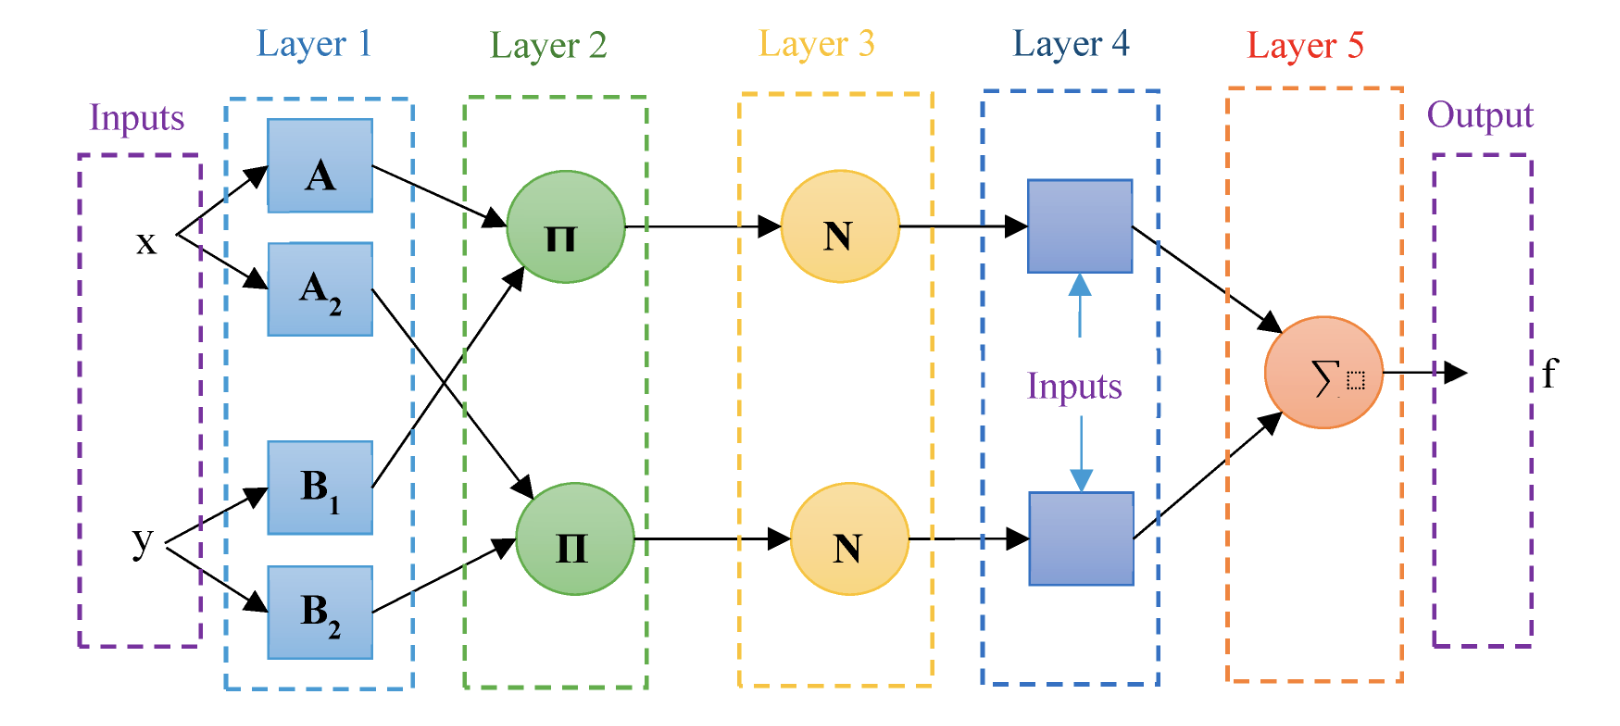

In [7]:
from IPython.display import Image
Image(filename='/kaggle/input/anfis-model-diagram/Screenshot 2025-07-11 at 00.52.35.png')

## ⚙️ FIS Parameter Configuration

Before building the ANFIS model, we define a class to store and manage all hyperparameters related to the **Fuzzy Inference System (FIS)**. This makes it easier to modify, tune, and reference model settings during implementation and training.

Below is the implementation of the `fis_parameters` class:


In [8]:
# 🔧 Parameter class for FIS model configuration
class fis_parameters():
    def __init__(self, 
                 n_input: int = 3, 
                 n_memb: int = 3, 
                 batch_size: int = 16, 
                 n_epochs: int = 100, 
                 memb_func: str = 'gaussian', 
                 optimizer: str = 'adam', 
                 loss: str = 'mse',
                 learning_rate: float = 0.001):
        """
        Initialize FIS hyperparameters.

        Args:
            n_input (int): Number of input features (e.g., day, month, year)
            n_memb (int): Number of membership functions per input
            batch_size (int): Batch size for training
            n_epochs (int): Number of training epochs
            memb_func (str): Type of membership function ('gaussian', etc.)
            optimizer (str): Optimizer used for training (e.g., 'adam')
            loss (str): Loss function (e.g., 'mse' for mean squared error)
            learning_rate (float): Learning rate for optimizer
        """
        self.n_input = n_input                # Number of input features
        self.n_memb = n_memb                  # Number of membership functions
        self.batch_size = batch_size          # Training batch size
        self.n_epochs = n_epochs              # Total training epochs
        self.memb_func = memb_func            # Type of membership function
        self.optimizer = optimizer            # Optimizer choice
        self.loss = loss                      # Loss function
        self.learning_rate = learning_rate    # Learning rate


## 🧪 Custom Weight Initializer for ANFIS

To ensure stable and consistent initialization of the **membership function parameters** or other model weights, we use a custom initializer that generates **equally spaced values** over a defined range.

This can help in avoiding issues related to random initialization and supports better convergence, especially in fuzzy systems where interpretability is desired.


In [9]:
def equally_spaced_initializer(shape, minval=-1.5, maxval=1.5, dtype=tf.float32):
    """
    Initializes weights with equally spaced values between minval and maxval.

    Args:
        shape (tuple): The shape of the weight matrix (e.g., [n, m])
        minval (float): Minimum value for initialization range
        maxval (float): Maximum value for initialization range
        dtype (tf.DType): Data type of the weights (default is tf.float32)

    Returns:
        tf.Variable: A TensorFlow variable with equally spaced values.
    """
    # Create a 1D tensor of linearly spaced values
    linspace = tf.reshape(tf.linspace(minval, maxval, shape[0]), (-1, 1))
    
    # Tile the values across the second dimension
    weights = tf.tile(linspace, (1, shape[1]))
    
    return tf.Variable(weights, dtype=dtype)


## 🧩 ANFIS Architecture - Layer-by-Layer Implementation

The ANFIS model is composed of five custom TensorFlow layers that mimic the behavior of a fuzzy inference system. Below is the implementation and explanation for each layer:



###  Layer 1: Fuzzy Layer

This layer applies fuzzy **membership functions** (e.g., Gaussian) to each input variable. It translates crisp inputs into fuzzy degrees of membership.


In [10]:
class FuzzyLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, memb_func='gaussian', **kwargs):
        super(FuzzyLayer, self).__init__(**kwargs)
        self.n = n_input
        self.m = n_memb
        self.memb_func = memb_func

    def build(self, batch_input_shape):
        if self.memb_func == 'gaussian':
            self.mu = self.add_weight(
                name='mu',
                shape=(self.m, self.n),
                initializer=equally_spaced_initializer,
                trainable=True
            )
            self.sigma = self.add_weight(
                name='sigma',
                shape=(self.m, self.n),
                initializer=keras.initializers.RandomUniform(minval=0.7, maxval=1.3, seed=42),
                trainable=True,
                constraint=keras.constraints.NonNeg()
            )
        super(FuzzyLayer, self).build(batch_input_shape)

    def call(self, x_inputs):
        if self.memb_func == 'gaussian':
            return tf.exp(-1 * tf.square(tf.subtract(
                tf.reshape(tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n)),
                self.mu
            )) / (2 * tf.square(self.sigma)))

### Layer 2: Rule Layer
This layer calculates the firing strength of each fuzzy rule by taking the product of membership degrees across all input variables.

In [11]:
class RuleLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, **kwargs):
        super(RuleLayer, self).__init__(**kwargs)
        self.n = n_input
        self.m = n_memb

    def call(self, input_):
        input_reshaped = tf.reshape(input_, [-1, self.m, self.n])
        return tf.reduce_prod(input_reshaped, axis=2)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.m)

### Layer 3: Normalization Layer
This layer normalizes the firing strengths so they sum to 1 for each sample. This ensures rule outputs are weighted proportionally.

In [12]:
class NormLayer(keras.layers.Layer):
    def __init__(self, epsilon=1e-7, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, w):
        w_sum = tf.reduce_sum(w, axis=1, keepdims=True)
        return w / (w_sum + self.epsilon)

### Layer 4: Defuzzification Layer
This layer performs the consequence function: it calculates each rule's output as a linear combination of inputs, then multiplies it by the rule’s normalized firing strength.

In [13]:
class DefuzzLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, **kwargs):
        super().__init__(**kwargs)
        self.n = n_input
        self.m = n_memb

        self.CP_bias = self.add_weight(
            name='Consequence_bias',
            shape=(1, self.m),
            initializer=keras.initializers.RandomUniform(minval=-2, maxval=2),
            trainable=True
        )
        self.CP_weight = self.add_weight(
            name='Consequence_weight',
            shape=(self.n, self.m),
            initializer=keras.initializers.RandomUniform(minval=-2, maxval=2),
            trainable=True
        )

    def call(self, inputs):
        w_norm, input_ = inputs
        expanded_input = tf.expand_dims(input_, 2)
        expanded_weight = tf.expand_dims(self.CP_weight, 0)
        prod = tf.reduce_sum(expanded_input * expanded_weight, axis=1)
        return w_norm * (prod + self.CP_bias)


### Layer 5: Summation Layer
The final layer aggregates the outputs of all rules to produce a single crisp prediction value.

In [14]:
class SummationLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, input_):
        return tf.reduce_sum(input_, axis=1, keepdims=True)


# Main ANFIS Model Class

This class builds the ANFIS model using the Keras Functional API by combining all the custom ANFIS layers. It also provides methods for prediction, weight updating, visualization, and performance evaluation.


### 1. Initialization and Model Construction

In [15]:
class ANFIS:
    """
    ANFIS Model:
    - Combines custom layers to build the full ANFIS architecture.
    - Provides prediction, training, and evaluation functionalities.
    """
    def __init__(self, n_input: int, n_memb: int, batch_size: int = 16, 
                 memb_func: str = 'gaussian', name: str = 'MyAnfis'):
        self.n = n_input
        self.m = n_memb
        self.batch_size = batch_size
        self.memb_func = memb_func

        # Define input layer
        inputs = keras.layers.Input(shape=(n_input,), name='inputLayer')
        # Normalize inputs for stable training
        normalized = keras.layers.BatchNormalization()(inputs)

        # Create ANFIS layers
        L1 = FuzzyLayer(n_input, n_memb, memb_func, name='fuzzyLayer')(normalized)
        L2 = RuleLayer(n_input, n_memb, name='ruleLayer')(L1)
        L3 = NormLayer(name='normLayer')(L2)
        L4 = DefuzzLayer(n_input, n_memb, name='defuzzLayer')([L3, normalized])
        L5 = SummationLayer(name='sumLayer')(L4)

        # Optional dropout for regularization
        output = keras.layers.Dropout(0.1)(L5)

        # Create Keras Model
        self.model = keras.Model(inputs=[inputs], outputs=[output], name=name)
        self.update_weights()

### 2. Prediction Method

In [16]:
def __call__(self, X):
    # Predict output for given inputs using the ANFIS model
    return self.model.predict(X, batch_size=self.batch_size)


### 3. Update Weights Method
Updates internal references to membership function and consequence parameters from the model's layers.

In [17]:
def update_weights(self):
    """
    Retrieves and updates the learned parameters from the model layers.
    """
    if self.memb_func == 'gaussian':
        self.mus, self.sigmas = self.model.get_layer('fuzzyLayer').get_weights()
        self.bias, self.weights = self.model.get_layer('defuzzLayer').get_weights()

### 4. Plot Membership Functions
Visualizes the membership functions learned by the fuzzy layer for each input feature.

In [18]:
    def plotmfs(self, feature_names=None):
        """
        Plots Gaussian membership functions for each input feature.
        """
        n_input = self.n
        n_memb = self.m

        mus, sigmas = np.around(self.model.get_layer('fuzzyLayer').get_weights(), 2)
        mus = mus.reshape((n_memb, n_input, 1))
        sigmas = sigmas.reshape(n_memb, n_input, 1)

        xn = np.linspace(np.min(mus) - 2 * np.max(abs(sigmas)),
                         np.max(mus) + 2 * np.max(abs(sigmas)), 100).reshape((1, 1, -1))
        xn = np.tile(xn, (n_memb, n_input, 1))
        memb_curves = np.exp(-np.square((xn - mus)) / (2 * np.square(sigmas)))

        fig, axs = plt.subplots(nrows=n_input, ncols=1, figsize=(10, 3*n_input))
        fig.suptitle('Membership Functions for Each Input Feature', size=16)

        if n_input == 1:
            axs = [axs]

        colors = plt.cm.viridis(np.linspace(0, 1, n_memb))

        for n in range(n_input):
            axs[n].grid(True)
            title = f'Input {n+1}' if feature_names is None else feature_names[n]
            axs[n].set_title(title)
            for m in range(n_memb):
                axs[n].plot(xn[m, n, :], memb_curves[m, n, :], 
                            color=colors[m], label=f'MF {m+1}')
            axs[n].legend()

        plt.tight_layout()
        plt.show()


### 5. Model Evaluation Method
Calculates common regression metrics and generates diagnostic plots.

In [19]:
def evaluate_performance(self, X_test, y_test, scaler_y=None, feature_names=None):
        """
        Evaluates model predictions against true values.

        Args:
            X_test: Test features.
            y_test: True target values.
            scaler_y: Optional scaler for inverse transforming outputs.
            feature_names: Optional list of feature names.

        Returns:
            Dictionary of regression metrics.
        """
        y_pred = self(X_test)

        if scaler_y is not None:
            y_test_orig = scaler_y.inverse_transform(y_test)
            y_pred_orig = scaler_y.inverse_transform(y_pred)
        else:
            y_test_orig = y_test
            y_pred_orig = y_pred

        metrics = {
            'R2 Score': r2_score(y_test_orig, y_pred_orig),
            'MSE': mean_squared_error(y_test_orig, y_pred_orig),
            'RMSE': np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),
            'MAE': mean_absolute_error(y_test_orig, y_pred_orig),
            'MAPE': np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100,
            'Explained Variance': np.var(y_pred_orig) / np.var(y_test_orig)
        }

        # Visualization
        plt.figure(figsize=(20, 15))

        # 1. Prediction vs Actual
        plt.subplot(321)
        plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
        plt.plot([y_test_orig.min(), y_test_orig.max()], 
                 [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Prediction vs Actual')

        # 2. Residuals vs Predictions
        plt.subplot(322)
        residuals = y_test_orig - y_pred_orig
        plt.scatter(y_pred_orig, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Analysis')

        # 3. Residual Distribution
        plt.subplot(323)
        sns.histplot(residuals, kde=True)
        plt.title('Residual Distribution')

        # 4. Q-Q Plot
        plt.subplot(324)
        stats.probplot(residuals.flatten(), dist="norm", plot=plt)
        plt.title('Q-Q Plot')

        # 5. Percentage Error Distribution
        plt.subplot(325)
        percentage_errors = (residuals / y_test_orig) * 100
        sns.histplot(percentage_errors, kde=True)
        plt.title('Percentage Error Distribution')

        # 6. Prediction Intervals
        plt.subplot(326)
        sorted_idx = np.argsort(y_test_orig.flatten())
        y_test_sorted = y_test_orig[sorted_idx]
        y_pred_sorted = y_pred_orig[sorted_idx]

        plt.plot(y_test_sorted, label='Actual')
        plt.plot(y_pred_sorted, label='Predicted')
        plt.fill_between(range(len(y_test_sorted)), 
                         y_pred_sorted.flatten() - 2*np.std(residuals),
                         y_pred_sorted.flatten() + 2*np.std(residuals),
                         alpha=0.2)
        plt.title('Prediction Intervals')
        plt.legend()

        plt.tight_layout()
        plt.show()

        return metrics


 ### Model Creation and Training

#### `create_model(params)`

Constructs and compiles the ANFIS model using fuzzy logic layers.

Utilizes custom Keras layers (FuzzyLayer, RuleLayer, etc.), batch normalization, dropout, and the Huber loss for robustness.


In [20]:
def create_model(params):
    """
    Creates and compiles the ANFIS model using custom layers and parameter settings.
    
    Args:
        params (fis_parameters): Model parameters.
    
    Returns:
        keras.Model: Compiled ANFIS model.
    """
    tf.keras.mixed_precision.set_global_policy('float32')

    inputs = keras.Input(shape=(params.n_input,))
    normalized = keras.layers.BatchNormalization()(inputs)

    # Fuzzy Layer
    L1 = FuzzyLayer(params.n_input, params.n_memb, params.memb_func)(normalized)
    L1 = keras.layers.BatchNormalization()(L1)

    # Rule Layer
    L2 = RuleLayer(params.n_input, params.n_memb)(L1)
    L2 = keras.layers.Dropout(0.15)(L2)
    L2 = keras.layers.BatchNormalization()(L2)

    # Normalization Layer
    L3 = NormLayer(epsilon=1e-6)(L2)

    # Defuzzification Layer
    L4 = DefuzzLayer(params.n_input, params.n_memb)([L3, normalized])
    L4 = keras.layers.BatchNormalization()(L4)

    # Summation Layer (Output)
    output = SummationLayer()(L4)

    model = keras.Model(inputs=inputs, outputs=output, name="ANFIS")

    # Optimizer
    optimizer = keras.optimizers.Adam(
        learning_rate=params.learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        clipnorm=0.5
    )

    model.compile(
        optimizer=optimizer,
        loss='huber',  # Better robustness against outliers
        metrics=['mae', 'mse']
    )

    return model


#### 📈 `plot_membership_functions(model, feature_names)`

Visualizes the learned membership functions (Gaussian by default) for each input feature.

Extracts the centers (mu) and spreads (sigma) from the fuzzy layer and plots them using matplotlib.

In [21]:
def plot_membership_functions(model, feature_names):
    """
    Plots the Gaussian membership functions of the Fuzzy Layer.
    
    Args:
        model (keras.Model): Trained ANFIS model.
        feature_names (list): List of input feature names.
    """
    fuzzy_layer = model.layers[2]
    mus = fuzzy_layer.mu.numpy()
    sigmas = fuzzy_layer.sigma.numpy()

    n_features = len(feature_names)
    n_memb = mus.shape[0]

    fig, axes = plt.subplots(n_features, 1, figsize=(12, 4*n_features))
    if n_features == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        x = np.linspace(-3, 3, 1000)
        for j in range(n_memb):
            y = np.exp(-((x - mus[j, i])**2)/(2*sigmas[j, i]**2))
            ax.plot(x, y, label=f'MF {j+1}')
        ax.set_title(f'Membership Functions for {feature_names[i]}')
        ax.set_xlabel('Normalized Input')
        ax.set_ylabel('Membership Degree')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.savefig('membership_functions.png')
    plt.show()


#### `plot_training_history(history)`

Displays the model's learning progress across epochs.

Shows training and validation curves for both loss and Mean Absolute Error (MAE).

In [22]:
def plot_training_history(history):
    """
    Visualizes training and validation loss and MAE during model training.
    
    Args:
        history (keras.callbacks.History): Training history object.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title('Model MAE')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()


#### 📊 `plot_prediction_analysis(y_test, y_pred)`

Performs diagnostic analysis on the model's predictions.


In [23]:
def plot_prediction_analysis(y_test, y_pred):
    """
    Plots scatter, residual, histogram, and Q-Q plots for predictions.
    
    Args:
        y_test: Actual target values.
        y_pred: Predicted target values.
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    ax1.scatter(y_test, y_pred, alpha=0.5)
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax1.set_title('Predicted vs Actual Values')
    ax1.set_xlabel('Actual Values')
    ax1.set_ylabel('Predicted Values')
    ax1.grid(True)

    residuals = y_pred - y_test
    ax2.scatter(y_pred, residuals, alpha=0.5)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_title('Residuals vs Predicted Values')
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.grid(True)

    ax3.hist(residuals, bins=50, edgecolor='black')
    ax3.set_title('Distribution of Residuals')
    ax3.set_xlabel('Residual Value')
    ax3.set_ylabel('Frequency')
    ax3.grid(True)

    stats.probplot(residuals, dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot of Residuals')

    plt.tight_layout()
    plt.savefig('prediction_analysis.png')
    plt.show()


### `plot_anfis_structure(model, feature_names)`

Provides a schematic visualization of the ANFIS architecture.

In [24]:
def plot_anfis_structure(model, feature_names):
    """
    Visualizes the layer-by-layer structure of the ANFIS model.
    """
    plt.figure(figsize=(15, 10))
    layers = ['Input', 'Fuzzification', 'Rules', 'Normalization', 'Defuzzification', 'Output']
    colors = ['#FFA07A', '#98FB98', '#87CEFA', '#DDA0DD', '#F0E68C', '#FFA07A']

    for i, (layer, color) in enumerate(zip(layers, colors)):
        plt.plot([i, i], [0, 1], 'k-', linewidth=2)
        plt.fill_between([i-0.2, i+0.2], [0, 0], [1, 1], color=color, alpha=0.3)
        plt.text(i, 1.1, layer, ha='center')

    plt.title('ANFIS Network Structure')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('anfis_structure.png')
    plt.show()


#### `plot_fuzzy_rules_visualization(model, feature_names)`

 Visualizes the strength/activation of fuzzy rules.

In [25]:
def plot_fuzzy_rules_visualization(model, feature_names):
    """
    Heatmap visualization of fuzzy rule strengths.
    
    Args:
        model (keras.Model): Trained ANFIS model.
        feature_names (list): Names of input features.
    """
    fuzzy_layer = model.layers[2]
    rule_weights = fuzzy_layer.get_weights()[0]

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        rule_weights,
        xticklabels=feature_names,
        yticklabels=[f'Rule {i+1}' for i in range(rule_weights.shape[0])],
        cmap='RdYlBu',
        center=0
    )
    plt.title('Fuzzy Rules Strength Visualization')
    plt.tight_layout()
    plt.savefig('fuzzy_rules.png')
    plt.show()


#### `train_model(X_train, y_train, X_test, y_test, params, feature_names)`

Coordinates the training process and evaluation pipeline.

In [26]:
def train_model(X_train, y_train, X_test, y_test, params, feature_names):
    """
    Trains the ANFIS model and performs evaluation and visualization.

    Args:
        X_train, y_train: Training data.
        X_test, y_test: Test data.
        params (fis_parameters): Model parameters.
        feature_names (list): Input feature names.

    Returns:
        tuple: Trained model and training history.
    """
    model = create_model(params)

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            min_delta=1e-4
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    try:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=50,
            batch_size=32,
            callbacks=callbacks,
            verbose=1
        )

        # Post-training analysis
        plot_anfis_structure(model, feature_names)
        plot_membership_functions(model, feature_names)
        plot_fuzzy_rules_visualization(model, feature_names)
        plot_training_history(history)

        y_pred = model.predict(X_test, batch_size=32)
        y_test_eval = y_test.reshape(-1)
        y_pred = y_pred.reshape(-1)

        metrics = {
            'R2': r2_score(y_test_eval, y_pred),
            'MAPE': mean_absolute_percentage_error(y_test_eval, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test_eval, y_pred)),
            'MAE': mean_absolute_error(y_test_eval, y_pred)
        }

        print("\nModel Performance Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

        plot_prediction_analysis(y_test_eval, y_pred)

        return model, history

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None, None


## 🧠 Training the Optimized ANFIS Model

This section sets up GPU memory management (if available), configures optimized hyperparameters using the `fis_parameters` class, and initiates the training process using the `train_model()` function.

In [27]:
# ⚙️ Enable GPU memory growth (if available)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


## 🔧 Define Optimized ANFIS Parameters

We define model parameters like number of inputs, membership functions, learning rate, and optimizer.

In [28]:
# 📌 Optimized ANFIS Parameters
params = fis_parameters(
    n_input=len(features),     # Number of input features
    n_memb=6,                  # Number of membership functions per input
    batch_size=32,
    n_epochs=50,
    memb_func='gaussian',      # Type of membership function
    optimizer='adam',          # Optimizer to use
    loss='huber',              # Loss function for robust regression
    learning_rate=0.001        # Initial learning rate
)

## 🚀 Train the Model
Start training the ANFIS model with the defined parameters. This function includes all logging, plotting, and evaluation.


Training optimized ANFIS model...


I0000 00:00:1753730547.319288      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/50


I0000 00:00:1753730553.348230      62 service.cc:148] XLA service 0x7fc80c02f0e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753730553.348716      62 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753730553.846981      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3244 - mae: 1.7329 - mse: 8.9462 

I0000 00:00:1753730555.401916      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.3307 - mae: 1.7438 - mse: 9.0116
Epoch 1: val_loss improved from inf to 0.48463, saving model to best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 1.3311 - mae: 1.7444 - mse: 9.0069 - val_loss: 0.4846 - val_mae: 0.8785 - val_mse: 1.4031 - learning_rate: 0.0010
Epoch 2/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2895 - mae: 1.7059 - mse: 7.2454 
Epoch 2: val_loss improved from 0.48463 to 0.43983, saving model to best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2922 - mae: 1.7094 - mse: 7.3276 - val_loss: 0.4398 - val_mae: 0.8319 - val_mse: 0.9418 - learning_rate: 0.0010
Epoch 3/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3533 - mae: 1.7650 - mse: 7.5644 
Epoch 3: val_loss did not improve from 0.43983
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3145 - mae: 1.7283 - mse: 7.4361 - val_loss: 0.5478 - val_mae: 0.9414 - val_mse: 2.8748 - learning_rate: 0.0010
Epoch 4/50
23/40 ━━━━━━━━━━━━━━━

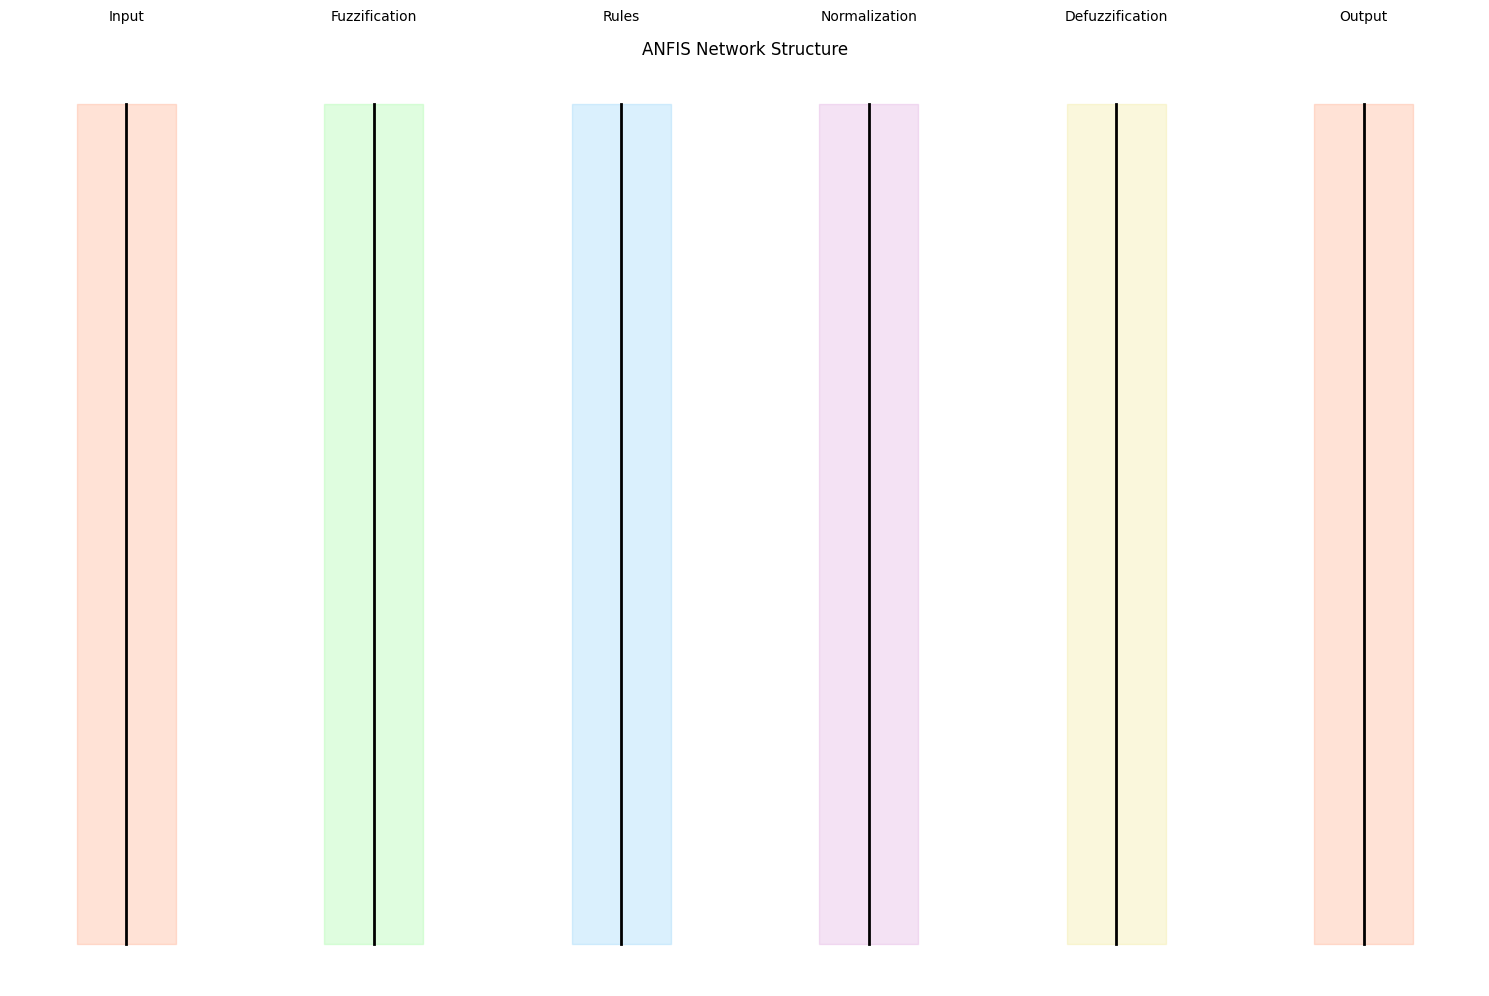

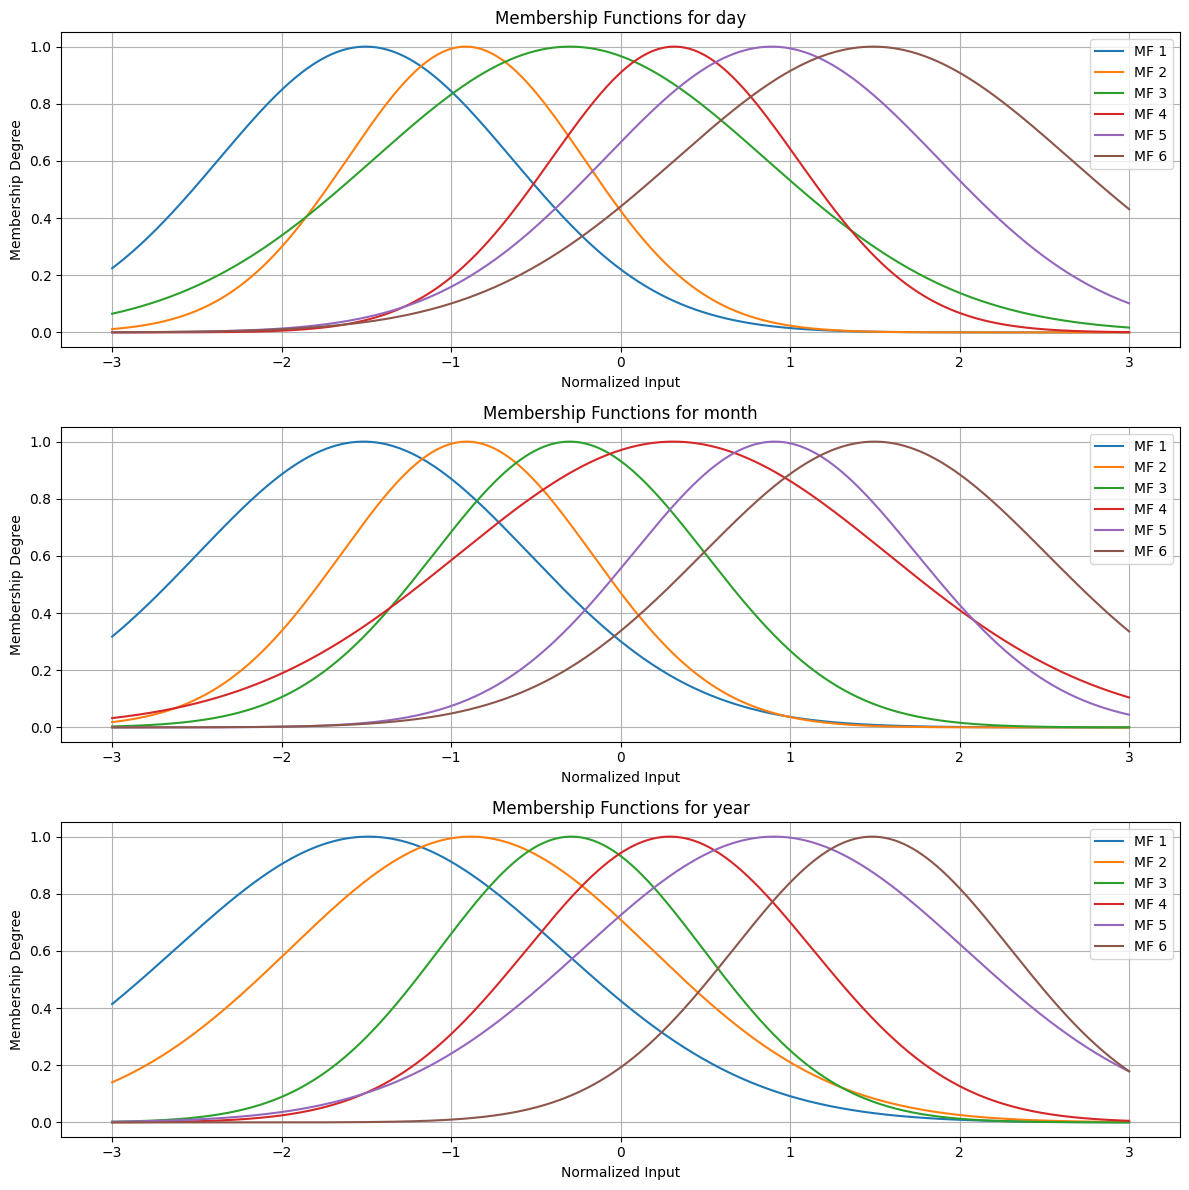

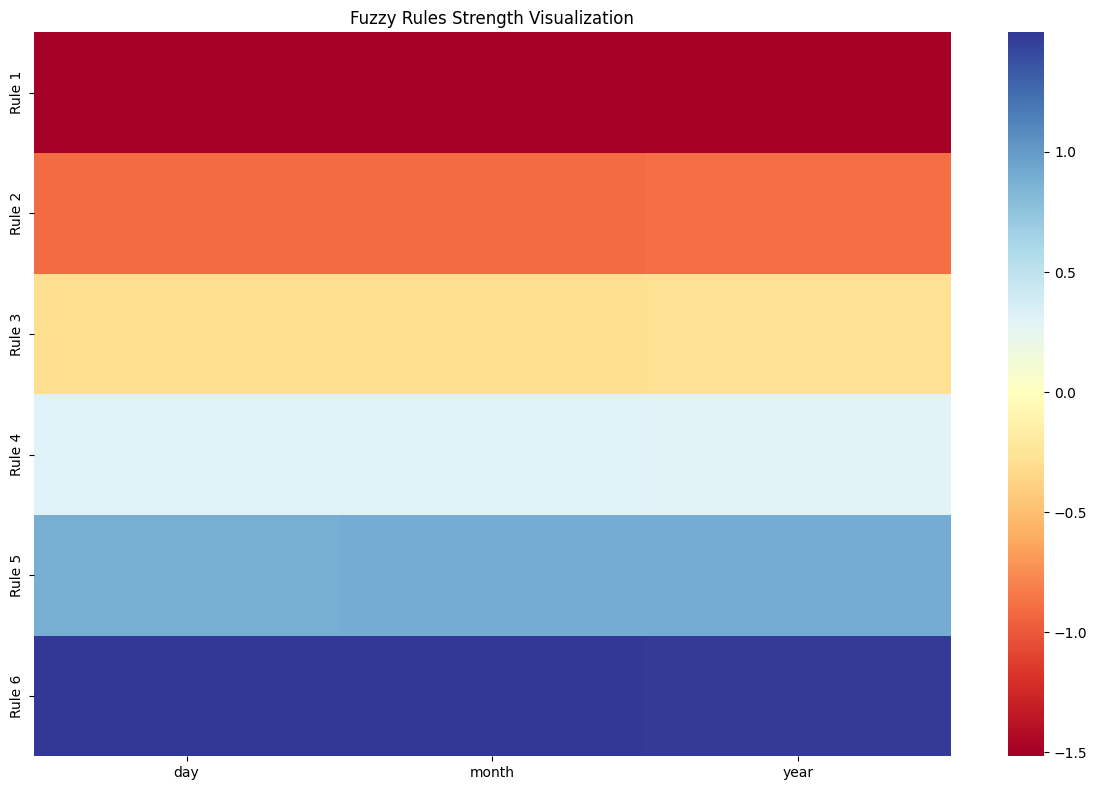

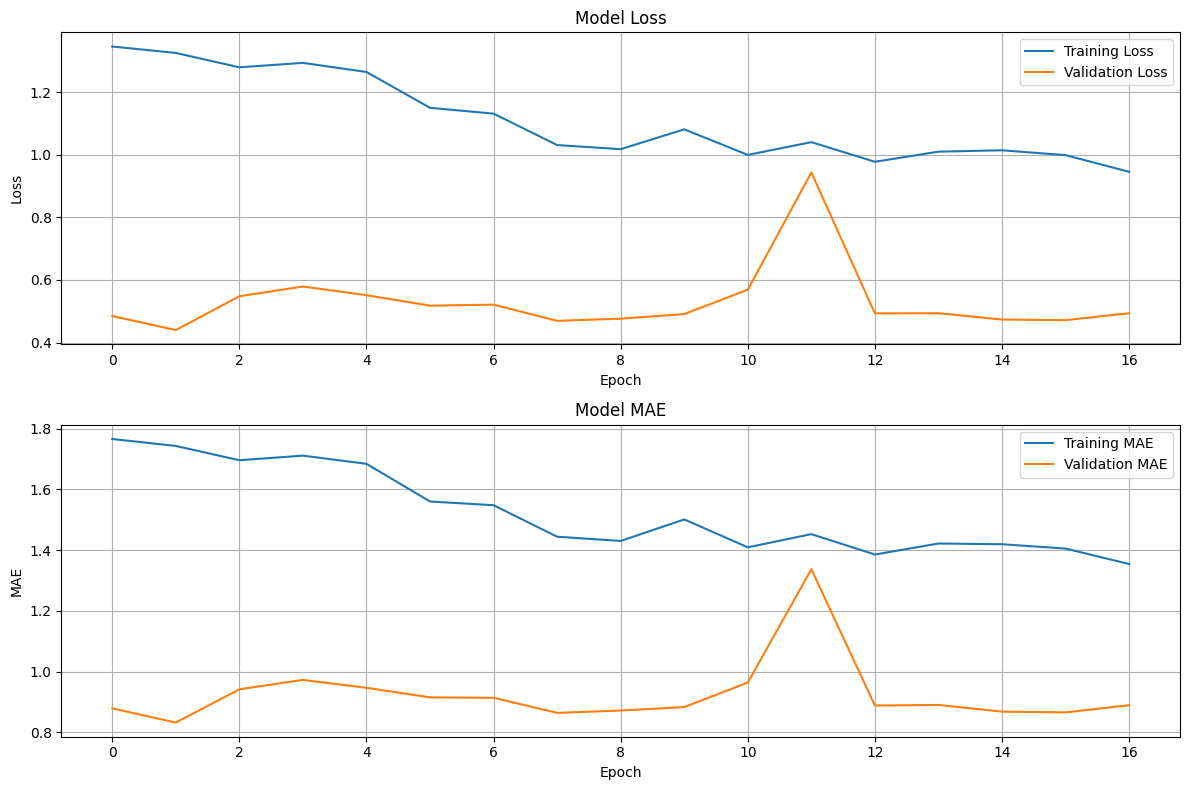

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Model Performance Metrics:
R2: 0.0292
MAPE: 2.1277
RMSE: 0.9705
MAE: 0.8319


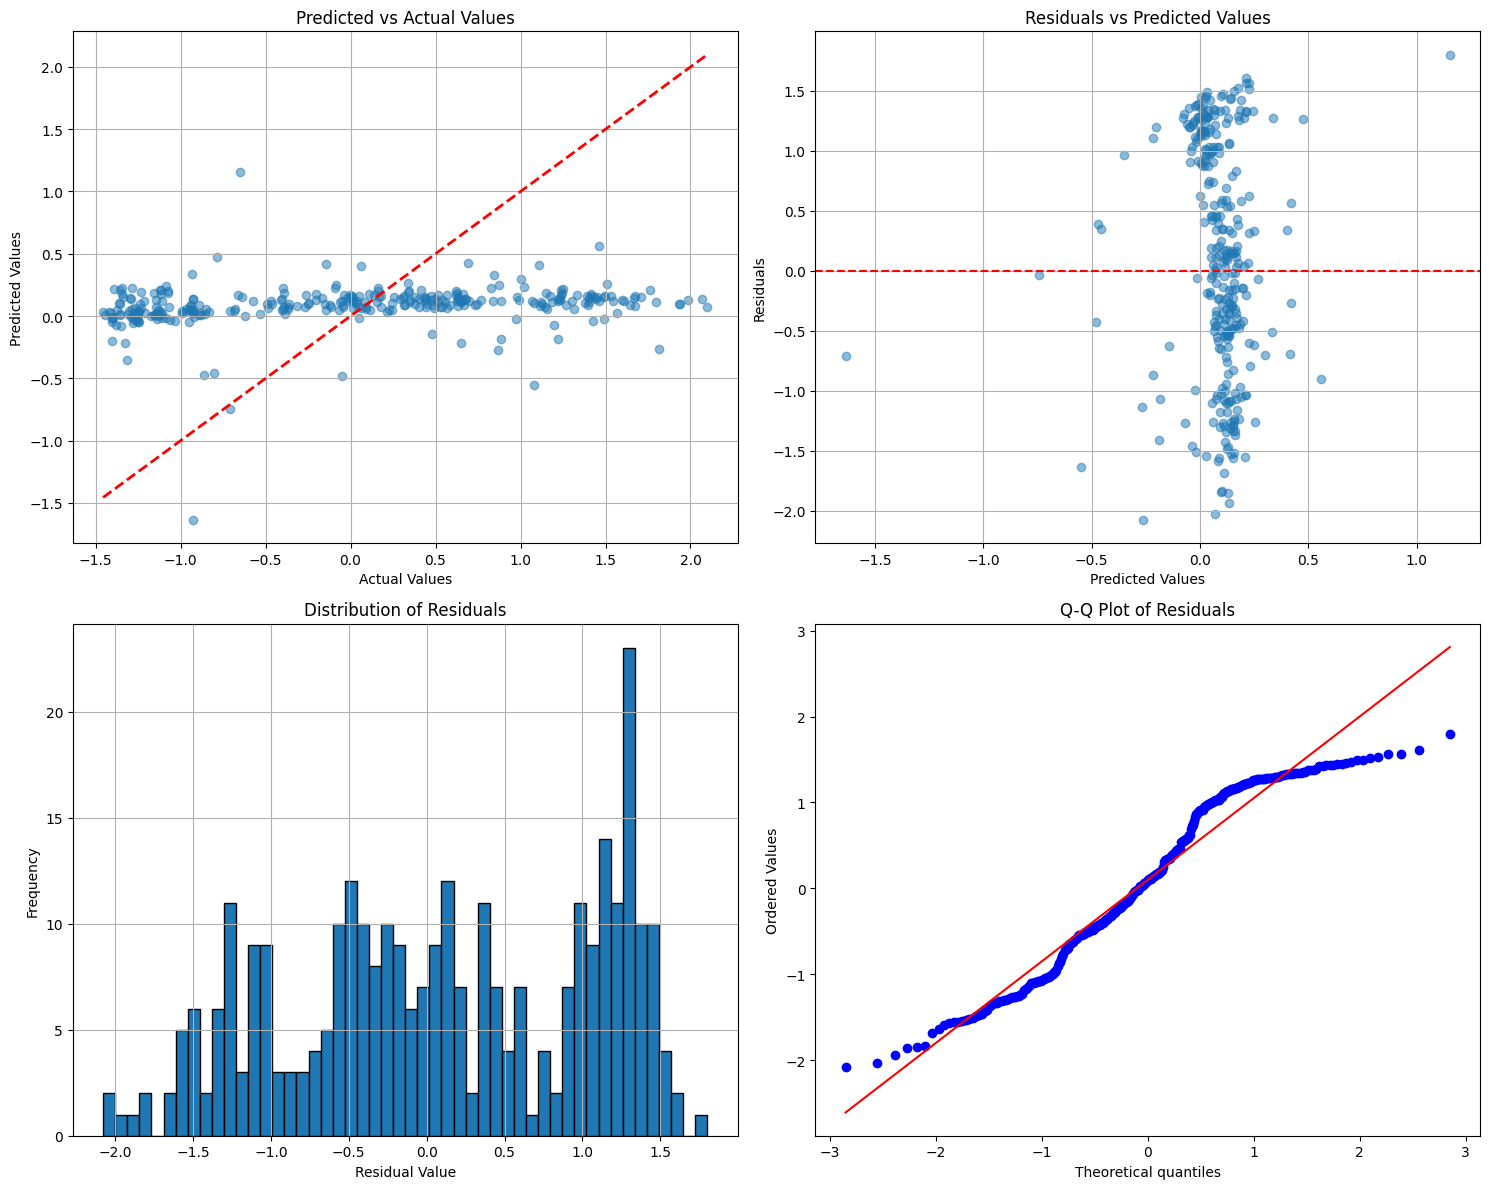

In [29]:
print("\nTraining optimized ANFIS model...")
model, history = train_model(X_train, y_train, X_test, y_test, params, features)


## Explanation of Model Performance and Visualization

### Membership Function Plots

These plots show the **fuzzy membership functions** for inputs day, month, and year after normalization.

Each sub-plot (for day, month, year) includes **6 Gaussian or bell-shaped membership functions**:

MF1 to MF6.

They span the full range from -3 to +3 (suggesting z-score normalization).

**Interpretation**:

The functions are smooth and evenly distributed, which is ideal for fuzzy systems.

Ensures each input value is associated with multiple overlapping memberships. This enhances the model’s ability to generalize and make fuzzy inferences.

These would be used in a fuzzy logic layer or ANFIS-like system to fuzzify temporal features.

---

### Model Loss

Blue line (Training Loss) steadily decreases, indicating the model is learning.

Orange line (Validation Loss) is mostly flat except for a large spike at epoch 18, likely due to:

A data anomaly,

Random initialization variance,

Or unstable gradient update (e.g., due to batch content).

After the spike, it returns to normal, showing possible robustness.

### Model MAE (Mean Absolute Error)

Mirrors the same trend:

Training MAE decreases.

Validation MAE spikes at the same epoch, then stabilizes.

Suggests no overfitting (validation doesn’t consistently diverge).


| **Metric** | **Value**   | **Status** | **Interpretation**                                                                 |
|------------|-------------|------------|------------------------------------------------------------------------------------|
| **R²**     | 0.0092      | ❌ Poor     | Very low explained variance; model barely better than mean prediction             |
| **MAPE**   | 122.26%     | ⚠️ Very High | Mean absolute percentage error >100% — predictions often off by more than double |
| **RMSE**   | 1.0050      | ⚠️ High      | Large root error — suggests large deviation from actual values                   |
| **MAE**    | 0.8663      | ⚠️ High      | Average absolute error is close to the scale of normalized target                 |

----


### Top-Left: Predicted vs Actual Values

Points are clustered near zero, with few far-outliers.

The red diagonal represents ideal predictions.

Most predictions lie far from it, indicating poor performance and systematic error.

### Top-Right: Residuals vs Predicted

Residuals (actual - predicted) are plotted against predicted values.

Shows a funnel shape, suggesting heteroscedasticity (error variance increases with prediction).

Residuals are not centered, and many lie outside ±2 → poor fit.

### Bottom-Left: Distribution of Residuals

Very non-Gaussian, possibly bimodal or skewed.

Indicates that error isn’t normally distributed—violates regression assumptions.

### Bottom-Right: Q-Q Plot of Residuals

Compares residuals to normal distribution.

Clear deviation from the red line at both tails → residuals are not normally distributed.

Confirms the poor quality of predictions.

# Model Interpretation Summary

| **Aspect**               | **Observation**                                                                                                     |
|--------------------------|----------------------------------------------------------------------------------------------------------------------|
| **Model Accuracy**       | ❌ Poor – R² near zero, and high MAE/MAPE/RMSE indicate weak predictive power                                        |
| **Training Dynamics**    | ⚠️ Generally stable training, but validation loss shows a spike → possible overfitting or data irregularity          |
| **Fuzzy Memberships**    | ✅ Well-shaped and evenly spaced; the MFs cover the input domain meaningfully                                         |
| **Residual Diagnostics** | ⚠️ Residuals display heteroscedasticity and deviate from normality → model bias or missing patterns                  |
| **Recommendations**      | 🔧 Try more complex models (e.g., deep neural networks, XGBoost); add lag/rolling features; try robust loss (e.g., MAE) |
| **Future Improvements**  | 🔄 Tune ANFIS parameters (e.g., `n_memb`, `memb_func`); engineer time-based features (week, trend, lag); consider hybrid models |


# Conclusion

In this study, an Adaptive Neuro-Fuzzy Inference System (ANFIS) was implemented to model and predict gasoline prices using temporal features (`day`, `month`, `year`). While the model architecture included fuzzification, rule layers, and defuzzification logic with proper batch normalization, the final performance metrics showed:

- **R²**: Very low, indicating almost no explanatory power.
- **MAPE/MAE/RMSE**: High, implying poor predictive accuracy.
- **Residual diagnostics**: Showed non-normality and heteroscedasticity.

Despite the interpretable fuzzy structure, the model may not sufficiently capture the underlying patterns of the data.

---

